In [12]:
from prophet import Prophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error,root_mean_squared_error
import warnings
warnings.filterwarnings('ignore')


In [1]:
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'matplotlib.backends.registry'

In [1]:
from pycaret.time_series import *

ModuleNotFoundError: No module named 'pycaret'

In [13]:
df = pd.read_csv(r'..\..\data\processed\Merch_ML.csv',index_col='Order_ID')
df.head()

,Order_Date,Buyer_Age,Sales_Price,Shipping_Charges,Sales_per_Unit,Quantity,Total_Sales,Rating,Product_ID,Order_Location,International_Shipping,Buyer_Gender,Product_Category_Clothing,Product_Category_Ornaments,Product_Category_Other
Order_ID,,,,,,,,,,,,,,,
189440,2024-07-21,30,100,0,100,1,100,4,0,15,0,1,1.0,0.0,0.0
187385,2024-07-20,32,100,0,100,1,100,3,0,6,0,1,1.0,0.0,0.0
181844,2024-07-21,26,9,40,49,1,49,2,1,1,1,0,0.0,0.0,1.0
197934,2024-08-19,28,9,0,9,2,18,3,1,18,0,1,0.0,0.0,1.0
122470,2024-01-06,19,10,0,10,3,30,5,2,11,0,0,0.0,0.0,1.0


In [14]:
df['Order_Date'] = pd.to_datetime(df['Order_Date'])

In [15]:
df.drop(df[(df['Order_Date'].dt.month == 11) & (df['Order_Date'].dt.year == 2024)].index,axis=0,inplace=True)

In [16]:
# Asegurar que las fechas sean de tipo datetime
df['Order_Date'] = pd.to_datetime(df['Order_Date'])

# Agrupar por mes y sumar las ventas
df_monthly = df.groupby(df['Order_Date'].dt.to_period('M'))['Total_Sales'].sum().reset_index()

# Convertir 'Order_Date' de Period a Timestamp
df_monthly['Order_Date'] = df_monthly['Order_Date'].dt.to_timestamp()

# Verificar los datos después de la agrupación
print(df_monthly.head())


  Order_Date  Total_Sales
0 2023-11-01        62358
1 2023-12-01        73033
2 2024-01-01        71802
3 2024-02-01        68089
4 2024-03-01        73291


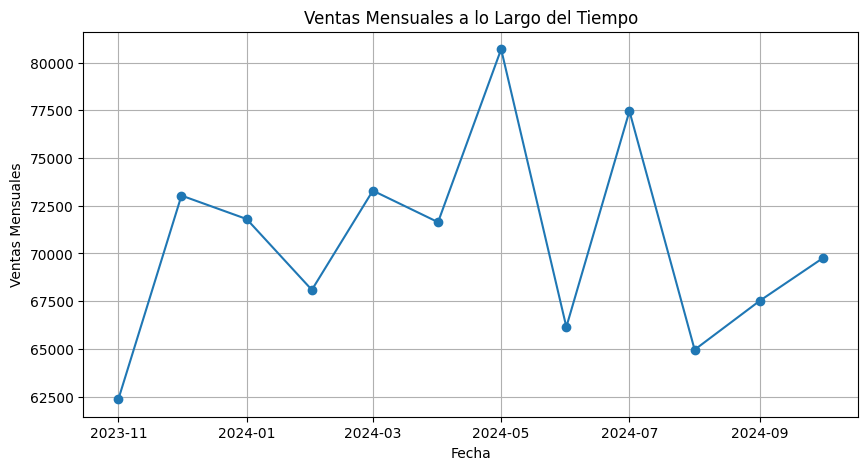

In [17]:
plt.figure(figsize=(10,5))
plt.plot(df_monthly['Order_Date'], df_monthly['Total_Sales'], marker='o', linestyle='-')
plt.xlabel('Fecha')
plt.ylabel('Ventas Mensuales')
plt.title('Ventas Mensuales a lo Largo del Tiempo')
plt.grid()
plt.show()

In [18]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_monthly['Total_Sales'])
print(f"p-value de Dickey-Fuller: {result[1]:.5f}")

# Interpretación:
if result[1] < 0.05:
    print("✅ La serie es estacionaria (p-value < 0.05)")
else:
    print("❌ La serie NO es estacionaria (p-value >= 0.05), necesitamos diferenciación.")


p-value de Dickey-Fuller: 0.00001
✅ La serie es estacionaria (p-value < 0.05)


In [24]:
print(f"Número de observaciones en df_monthly: {len(df_monthly)}")


Número de observaciones en df_monthly: 12


ValueError: Can only compute partial correlations for lags up to 50% of the sample size. The requested nlags 10 must be < 6.

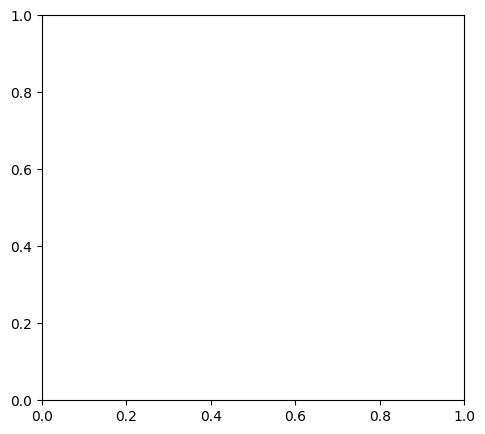

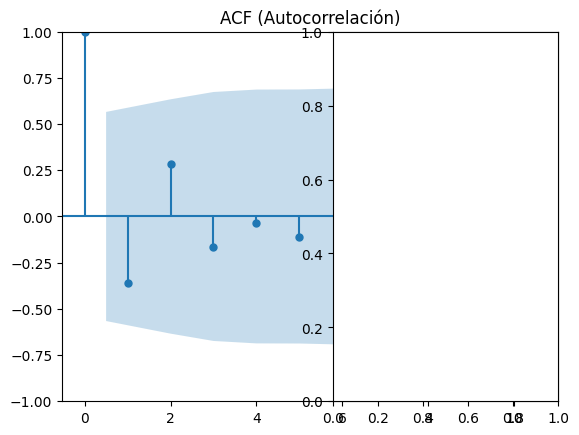

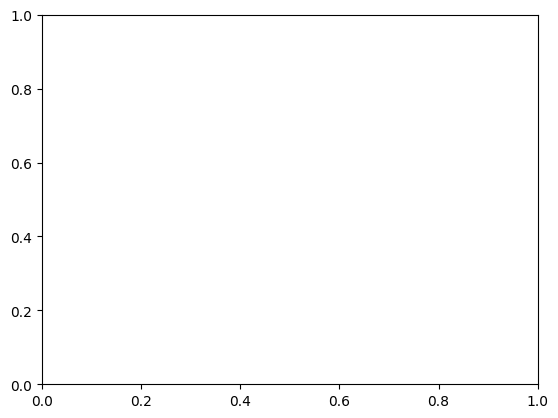

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12,5))

plt.subplot(121)
plot_acf(df_monthly['Total_Sales'].dropna(), lags=10)  # Ver ACF para determinar `q`
plt.title('ACF (Autocorrelación)')

plt.subplot(122)
plot_pacf(df_monthly['Total_Sales'].dropna(), lags=10)  # Ver PACF para determinar `p`
plt.title('PACF (Autocorrelación Parcial)')

plt.show()


In [22]:
from statsmodels.tsa.arima.model import ARIMA

# Definir valores de p, d y q (ajustar según ACF/PACF)
p, d, q = 1, 0, 1  # Ajusta estos valores según tu análisis

# Entrenar ARIMA
model = ARIMA(df_monthly['Total_Sales'], order=(p, d, q))
model_fit = model.fit()

# Ver resumen del modelo
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:            Total_Sales   No. Observations:                   12
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -118.143
Date:                Fri, 07 Mar 2025   AIC                            244.287
Time:                        10:54:54   BIC                            246.226
Sample:                             0   HQIC                           243.568
                                 - 12                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       7.056e+04   1547.283     45.604      0.000    6.75e+04    7.36e+04
ar.L1         -0.6368      0.859     -0.742      0.458      -2.320       1.046
ma.L1          0.2654      1.444      0.184      0.8

In [23]:
# Hacer predicciones para los próximos 3 meses
forecast = model_fit.forecast(steps=3)

# Crear un DataFrame con las fechas futuras
future_dates = pd.date_range(start=df_monthly['Order_Date'].max(), periods=4, freq='M')[1:]
forecast_df = pd.DataFrame({'Fecha': future_dates, 'Predicción': forecast})

print("\nPredicciones para los próximos 3 meses:")
print(forecast_df)



Predicciones para los próximos 3 meses:
        Fecha    Predicción
12 2024-11-30  70769.501392
13 2024-12-31  70430.673299
14 2025-01-31  70646.453820


In [12]:
df['Total_Sales'] = np.log1p(df['Total_Sales'])